In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np

def create_simple_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [2]:
def create_resnet50(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
      layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [3]:
def train_model(model, model_name, x_train, y_train):
    print(f"Training {model_name}...")
    start_time = time.time()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=0)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"{model_name} training time: {train_time:.2f} seconds")
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return train_time, history

In [4]:
def evaluate_model(model, model_name, x_test, y_test):
  print(f"Evaluating {model_name}...")
  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
  print(f"{model_name} Test Loss: {loss:.4f}")
  print(f"{model_name} Test Accuracy: {accuracy:.4f}")
  return loss, accuracy

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [6]:
input_shape = (32, 32, 3)
num_classes = 10

In [7]:
simple_cnn_model = create_simple_cnn(input_shape, num_classes)
resnet50_model = create_resnet50(input_shape, num_classes)

In [8]:
models = {
            "Simple CNN": simple_cnn_model,
           "ResNet50": resnet50_model,
}

Training Simple CNN...
Simple CNN training time: 43.64 seconds


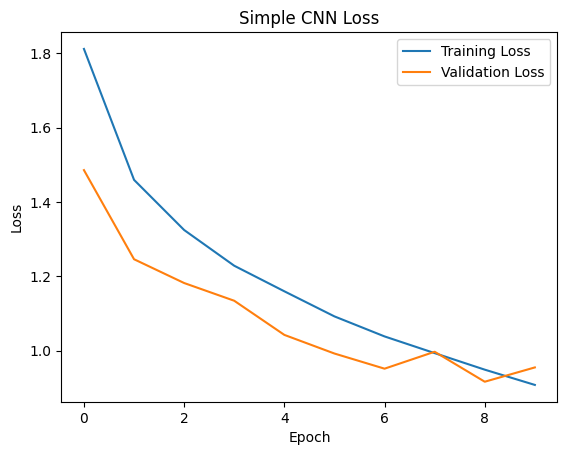

Evaluating Simple CNN...
Simple CNN Test Loss: 0.9656
Simple CNN Test Accuracy: 0.6661
Training ResNet50...
ResNet50 training time: 103.75 seconds


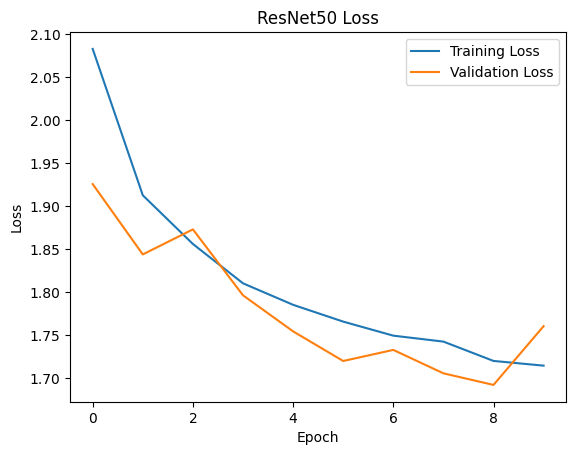

Evaluating ResNet50...
ResNet50 Test Loss: 1.7594
ResNet50 Test Accuracy: 0.3627


In [9]:
results = {}
for model_name, model in models.items():
  train_time, _ = train_model(model, model_name, x_train, y_train)
  test_loss, test_accuracy = evaluate_model(model, model_name, x_test, y_test)
  results[model_name] = {"Train Time": train_time, "Test Loss": test_loss, "Test Accuracy": test_accuracy}

In [10]:
print("\nResults:")
for model_name, metrics in results.items(): print(f"{model_name}:")
for metric, value in metrics.items(): print(f"{metric}: {value}")
print()


Results:
Simple CNN:
ResNet50:
Train Time: 103.75078010559082
Test Loss: 1.759395718574524
Test Accuracy: 0.3626999855041504



Inception Net

In [11]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
percent_data = 1
num_samples = int(len(train_images) * percent_data)
train_images = train_images[:num_samples]
train_labels = train_labels[:num_samples]

In [12]:
num_classes = 10
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
from skimage.transform import resize
resized_train_images = np.array([resize(img, (75, 75)) for img in train_images])
resized_test_images = np.array([resize(img, (75, 75)) for img in test_images])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True )
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
val_split = 0.2
val_size = int(val_split * len(resized_train_images))
val_images = resized_train_images[:val_size]
val_labels = train_labels[:val_size]
train_images = resized_train_images[val_size:]
train_labels = train_labels[val_size:]

In [ ]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = test_datagen.flow(val_images, val_labels, batch_size=32)

In [ ]:
def create_inception_model(include_top=False):
  base_model = InceptionV3(weights='imagenet', include_top=include_top, input_shape=(75, 75, 3))
  if not include_top:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x) model = Model(inputs=base_model.input, outputs=predictions)
  else:
    model = base_model
  return model

In [ ]:
# Inception Model
inception_model = create_inception_model(include_top=False)

#Freeze base model layers for transfer learning
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
inception_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

In [ ]:
test_loss, test_acc = inception_model.evaluate(test_datagen.flow(resized_test_images, test_labels, batch_size=32))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Dense Net

In [ ]:
import numpy as np
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model


In [ ]:
def create_densenet_model(include_top=False):
  base_model = DenseNet121(weights='imagenet', include_top=include_top, input_shape=(75, 75, 3))
  if not include_top:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add custom layers for classification (adjust units as needed) x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
  else:
    model = base_model
  return model

In [ ]:
densenet_model = create_densenet_model(include_top=False)

In [ ]:
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
densenet_model.fit(
                  train_generator,
                  epochs=10,
                  validation_data=validation_generator
)

In [ ]:
test_loss_densenet, test_acc_densenet = densenet_model.evaluate(test_datagen.flow(resized_test_images, test_labels, batch_size=32))

In [ ]:
print("DenseNet Model Test Loss:", test_loss_densenet)
print("DenseNet Model Test Accuracy:", test_acc_densenet)